# Delinquency Telecom Model
### Definition: 
- __Delinquency__ is a condition that arises when an activity or situation does not occur at its scheduled (or expected) date i.e., it occurs later than expected.

### Use Case: 
- Many donors, experts, and microfinance institutions (MFI) have become convinced that using mobile financial services (MFS) is more convenient and efficient, and less costly, than the traditional high-touch model for delivering microfinance services. MFS becomes especially useful when targeting the unbanked poor living in remote areas. The implementation of MFS, though, has been uneven with both significant challenges and successes.
- Today, microfinance is widely accepted as a poverty-reduction tool, representing $70 billion in outstanding loans and a global outreach of 200 million clients.

- One of our Client in Telecom collaborates with an MFI to provide micro-credit on mobile balances to be paid back in 5 days. The Consumer is believed to be delinquent if he deviates from the path of paying back the loaned amount within 5 days

### Machine Learning problem : 
- Create a delinquency model which can predict in terms of a probability for each loan transaction, whether the customer will be paying back the loaned amount within 5 days of insurance of loan (Label ‘1’ & ’0’)
- Basically a Binary Classification setup

### Real-world/Business objectives and constraints.
- No low-latency requirement.
- Interpretability is important.
- Probability of a data-point belonging to each class is needed.

### Performance Metric

- Log-loss (Since probabilities is our concern)
- Confusion matrix (Also want to check some precision and recalls)

In [1]:
cd drive/My\ Drive/Algo8

/content/drive/My Drive/Algo8


In [3]:
!pip install catboost

     |████████████████████████████████| 64.8MB 49kB/s 


In [4]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
sns.set(color_codes=True)
import os
from sklearn.model_selection import GridSearchCV 
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Boosting Algorithms :
from xgboost  import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, normalized_mutual_info_score
from sklearn.linear_model import SGDClassifier


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
train = pd.read_csv('sample_data_intw.csv')

## Exploratory Data Analysis and Data Preprocessing

In [6]:
train.head()

,Unnamed: 0,label,msisdn,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pcircle,pdate
0,1,0,21408I70789,272.0,3055.050000,3065.150000,220.13,260.13,2.0,0.0,1539,2,21.0,3078.0,1539.0,7.50,2,21,3078,1539.0,7.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000,UPW,2016-07-20
1,2,1,76462I70374,712.0,12122.000000,12124.750000,3691.26,3691.26,20.0,0.0,5787,1,0.0,5787.0,5787.0,61.04,1,0,5787,5787.0,61.04,0.0,0.0,0,0,1,12,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000,UPW,2016-08-10
2,3,1,17943I70372,535.0,1398.000000,1398.000000,900.13,900.13,3.0,0.0,1539,1,0.0,1539.0,1539.0,66.32,1,0,1539,1539.0,66.32,0.0,0.0,0,0,1,6,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000,UPW,2016-08-19
3,4,1,55773I70781,241.0,21.228000,21.228000,159.42,159.42,41.0,0.0,947,0,0.0,0.0,0.0,0.00,1,0,947,947.0,2.50,0.0,0.0,0,0,2,12,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000,UPW,2016-06-06
4,5,1,03813I82730,947.0,150.619333,150.619333,1098.90,1098.90,4.0,0.0,2309,7,2.0,20029.0,2309.0,29.00,8,2,23496,2888.0,35.00,0.0,0.0,0,0,7,42,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333,UPW,2016-06-22


In [7]:
train.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
print("Size of Train data = {}".format(train.shape))

Size of Train data = (209593, 36)


## Checks for Null values

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   label                 209593 non-null  int64  
 1   msisdn                209593 non-null  object 
 2   aon                   209593 non-null  float64
 3   daily_decr30          209593 non-null  float64
 4   daily_decr90          209593 non-null  float64
 5   rental30              209593 non-null  float64
 6   rental90              209593 non-null  float64
 7   last_rech_date_ma     209593 non-null  float64
 8   last_rech_date_da     209593 non-null  float64
 9   last_rech_amt_ma      209593 non-null  int64  
 10  cnt_ma_rech30         209593 non-null  int64  
 11  fr_ma_rech30          209593 non-null  float64
 12  sumamnt_ma_rech30     209593 non-null  float64
 13  medianamnt_ma_rech30  209593 non-null  float64
 14  medianmarechprebal30  209593 non-null  float64
 15  

In [10]:
train.isnull().sum()

label                   0
msisdn                  0
aon                     0
daily_decr30            0
daily_decr90            0
rental30                0
rental90                0
last_rech_date_ma       0
last_rech_date_da       0
last_rech_amt_ma        0
cnt_ma_rech30           0
fr_ma_rech30            0
sumamnt_ma_rech30       0
medianamnt_ma_rech30    0
medianmarechprebal30    0
cnt_ma_rech90           0
fr_ma_rech90            0
sumamnt_ma_rech90       0
medianamnt_ma_rech90    0
medianmarechprebal90    0
cnt_da_rech30           0
fr_da_rech30            0
cnt_da_rech90           0
fr_da_rech90            0
cnt_loans30             0
amnt_loans30            0
maxamnt_loans30         0
medianamnt_loans30      0
cnt_loans90             0
amnt_loans90            0
maxamnt_loans90         0
medianamnt_loans90      0
payback30               0
payback90               0
pcircle                 0
pdate                   0
dtype: int64

In [11]:
train['pcircle'].value_counts()

UPW    209593
Name: pcircle, dtype: int64

In [12]:
train.drop('pcircle',axis=1,inplace=True) #Same value , so not much informative

In [13]:
# Checking for duplicate values
print("Number of duplicate values in train data is "+str(sum(train.duplicated())))

Number of duplicate values in train data is 1


### Separating features and class labels

In [37]:
X = train
X = X.drop(["label"], axis = 1)

y = train['label']

In [117]:
X.shape , y.shape

((209593, 32), (209593,))

## Checking Data Imbalances

1    183431
0     26162
Name: label, dtype: int64


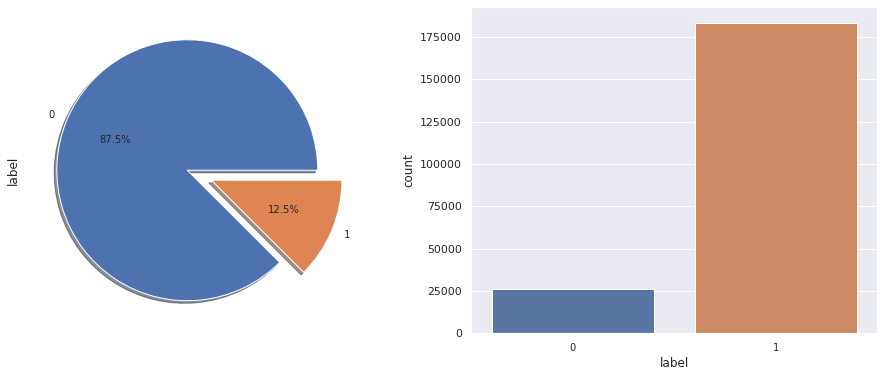

In [39]:
print(train['label'].value_counts())
f,ax=plt.subplots(1,2,figsize=(16,6))
labels = ['0', '1']
train['label'].value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=True,labels=labels,fontsize=10)
sns.countplot('label',data=train, ax=ax[1])
ax[1].set_xticklabels(['0', '1'], fontsize=10)
plt.show()

- Imbalanced Data

In [17]:
## SEE the number of of outliers 

Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print('No. of outliers in all the fields: ',((train < (Q1 - 1.5 * IQR)) | (train > (Q3 + 1.5 * IQR))).sum())

No. of outliers in all the fields:  amnt_loans30            10416
amnt_loans90            12590
aon                      3607
cnt_da_rech30            4114
cnt_da_rech90            5367
cnt_loans30              7817
cnt_loans90             11523
cnt_ma_rech30           11294
cnt_ma_rech90           14155
daily_decr30            16350
daily_decr90            18187
fr_da_rech30             1579
fr_da_rech90              865
fr_ma_rech30            11450
fr_ma_rech90            26845
label                   26162
last_rech_amt_ma        20864
last_rech_date_da        6732
last_rech_date_ma       20145
maxamnt_loans30         30400
maxamnt_loans90         28648
medianamnt_loans30      14148
medianamnt_loans90      12169
medianamnt_ma_rech30    24928
medianamnt_ma_rech90    25457
medianmarechprebal30    27252
medianmarechprebal90    25933
msisdn                      0
payback30               16532
payback90               17850
pdate                       0
rental30                18526
rent

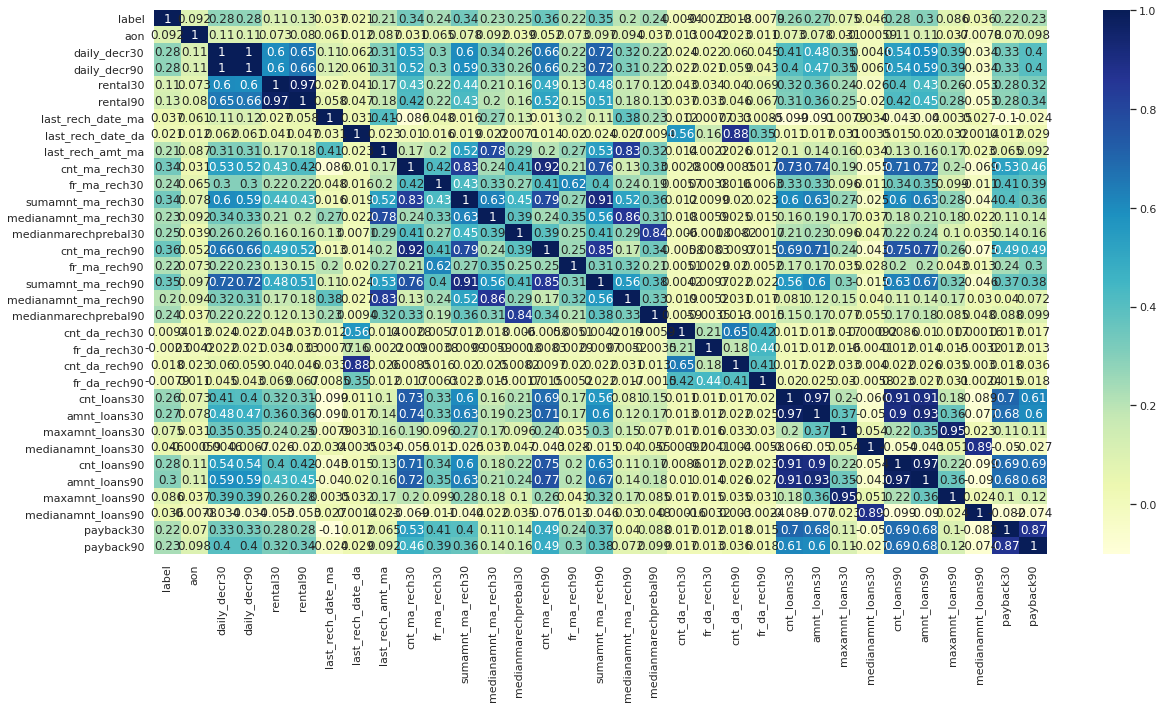

In [18]:
# Correlations
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(train.corr(method='spearman'), annot=True, cmap="YlGnBu")

### Convert all columns to numeric

In [40]:
for i in X.columns:
    if i=='pdate':
        continue
    else:
        X[i]=pd.to_numeric(X[i],errors='coerce')

In [41]:
train['msisdn'].value_counts()

04581I85330    7
47819I90840    7
29191I82738    6
43430I70786    6
71742I90843    6
              ..
06791I70785    1
09434I82730    1
65674I70370    1
76802I89231    1
18134I85330    1
Name: msisdn, Length: 186243, dtype: int64

In [42]:
X.drop(['msisdn','pdate'],axis=1,inplace=True) # Not much informative in this case

In [22]:
X = np.array(X)

## Train Test Split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.25,random_state = 42)

## Standardize the features


In [95]:
#Use standardscaler to standardize the features

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_cv  = sc.transform(X_cv)
X_test  = sc.transform(X_test)

In [96]:
(len(X_train),len(y_train),len(X_test),len(y_test),len(X_cv),len(y_cv))

(117895, 117895, 52399, 52399, 39299, 39299)

## UTILITY FUNCTIONS

In [25]:
def plot_matrix(matrix,labels):
    plt.figure(figsize=(20,7))    
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    cm = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    recall_table =(((cm.T)/(cm.sum(axis=1))).T)
    # How did we calculateed recall_table :
    # divide each element of the confusion matrix with the sum of elements in that column    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]
    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    precision_table =(cm/cm.sum(axis=0))
    # How did we calculateed precision_table :
    # divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]    
    print()
    print("-"*20, "Confusion matrix", "-"*20)
    plot_matrix(cm,labels)

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plot_matrix(precision_table,labels)    
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plot_matrix(recall_table,labels)

In [32]:
#Data preparation for ML models.

#Misc. functionns for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [33]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [100]:
Xr = np.array(X_test)
yr = np.array(y_test)

## NOTE : 
- Since we want a probabilistic interpretation from the model so we will use __LogLoss__ as the Metric here

## Prediction using a 'Random' Model
- We build a random model to compare the log- loss of random model with the ML models used by us. 
- In a 'Random' Model, we generate the '2' class probabilites randomly such that they sum to 1.




Log loss on Cross Validation Data using Random Model 0.8894681457527356
Log loss on Test Data using Random Model 0.8821834697913175

-------------------- Confusion matrix --------------------


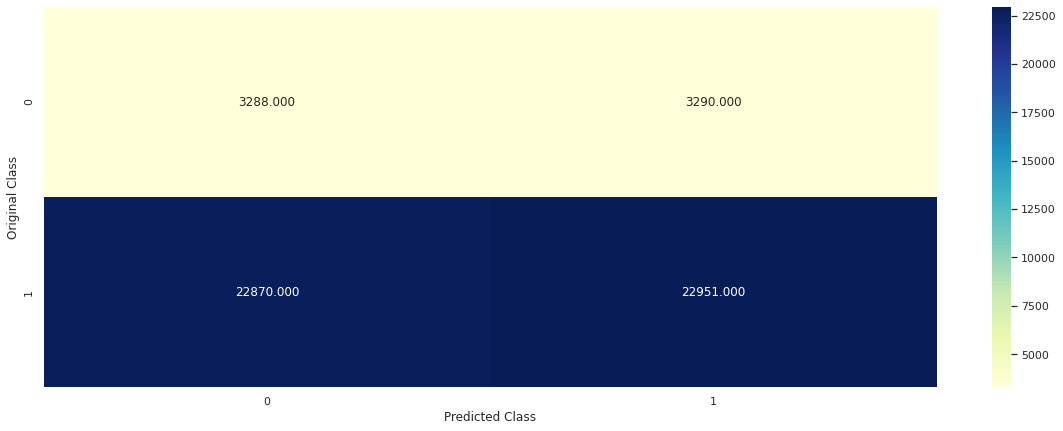

-------------------- Precision matrix (Columm Sum=1) --------------------


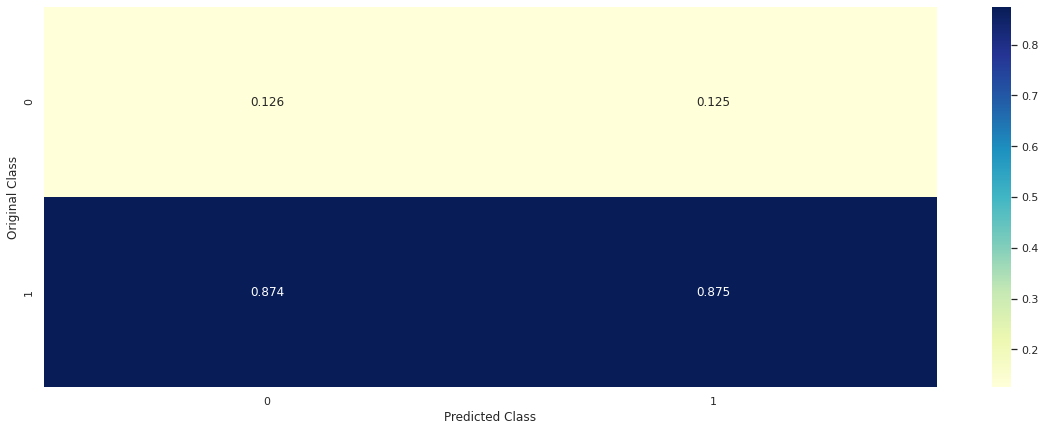

-------------------- Recall matrix (Row sum=1) --------------------


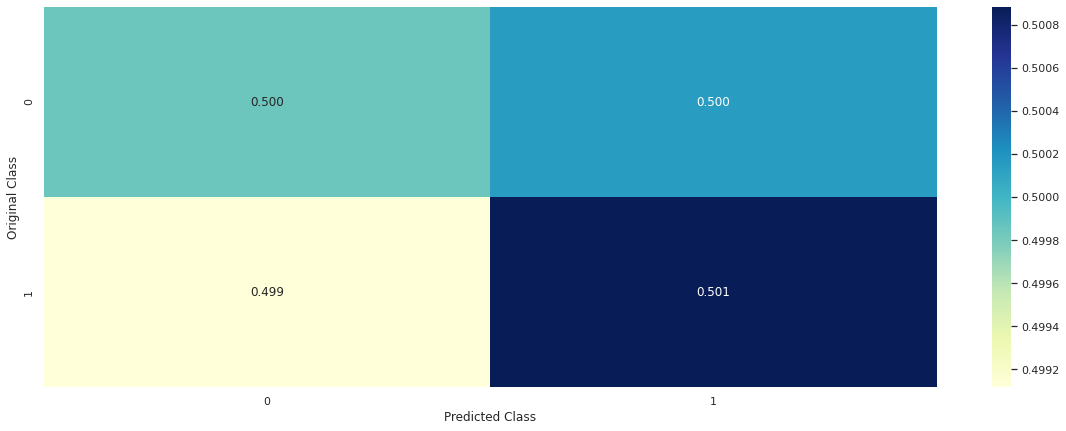

In [97]:
# We need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
# We create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,2)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## Logistic Regression with class balancing

for alpha = 1e-06
Log Loss : 0.351791337006705
for alpha = 1e-05
Log Loss : 0.3320307346193461
for alpha = 0.0001
Log Loss : 0.3058021701302629
for alpha = 0.001
Log Loss : 0.2979462032962917
for alpha = 0.01
Log Loss : 0.29844309560647647
for alpha = 0.1
Log Loss : 0.30031521568767255
for alpha = 1
Log Loss : 0.30476584119358274
for alpha = 10
Log Loss : 0.30754576504364484
for alpha = 100
Log Loss : 0.3081048242033373
for alpha = 1000
Log Loss : 0.30813211508897875
for alpha = 10000
Log Loss : 0.30811283799886485
for alpha = 100000
Log Loss : 0.30870186930726273


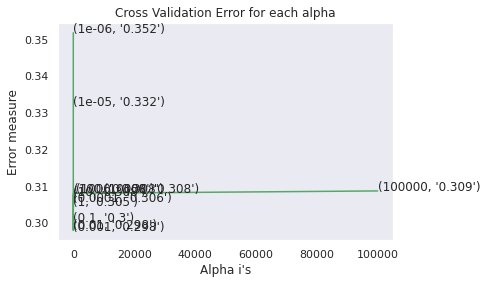

For values of best alpha =  0.001 The train log loss is: 0.29879942213560184
For values of best alpha =  0.001 The cross validation log loss is: 0.2979462032962917
For values of best alpha =  0.001 The test log loss is: 0.3025684286785776


In [99]:
alpha = [10 ** x for x in range(-6, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.2979462032962917
Number of mis-classified points : 0.12287844474414107

-------------------- Confusion matrix --------------------


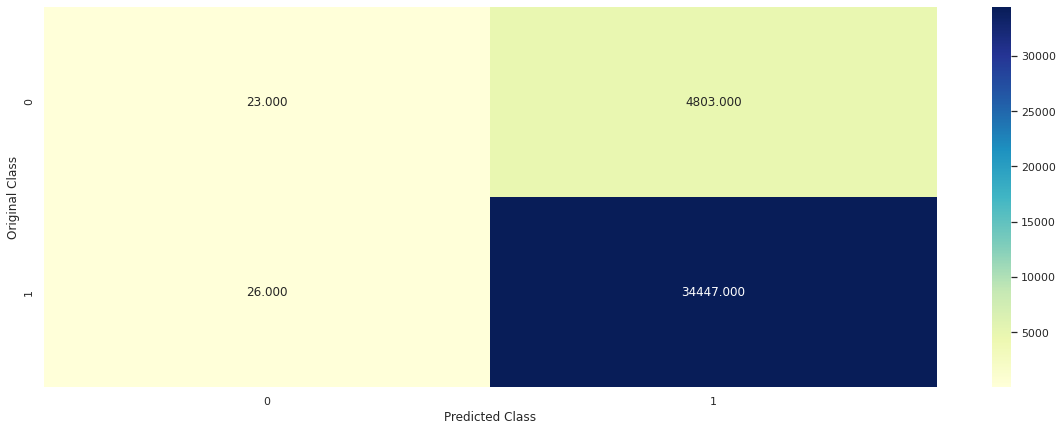

-------------------- Precision matrix (Columm Sum=1) --------------------


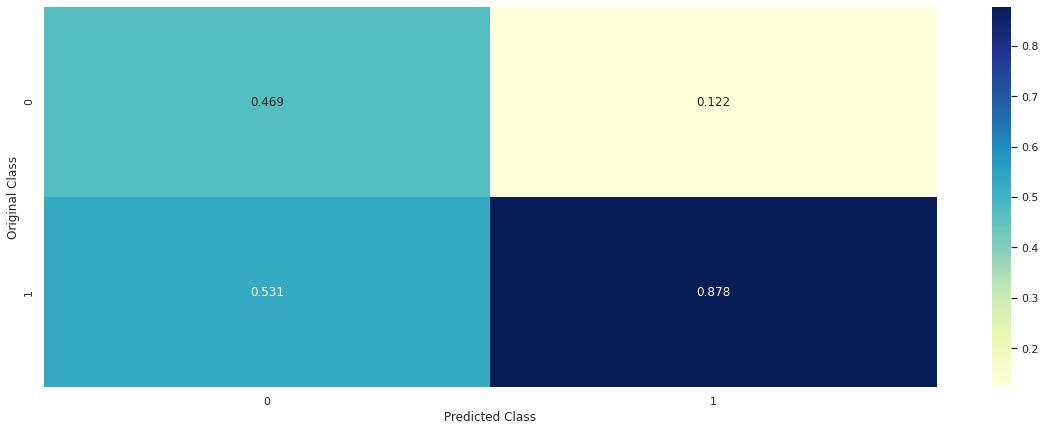

-------------------- Recall matrix (Row sum=1) --------------------


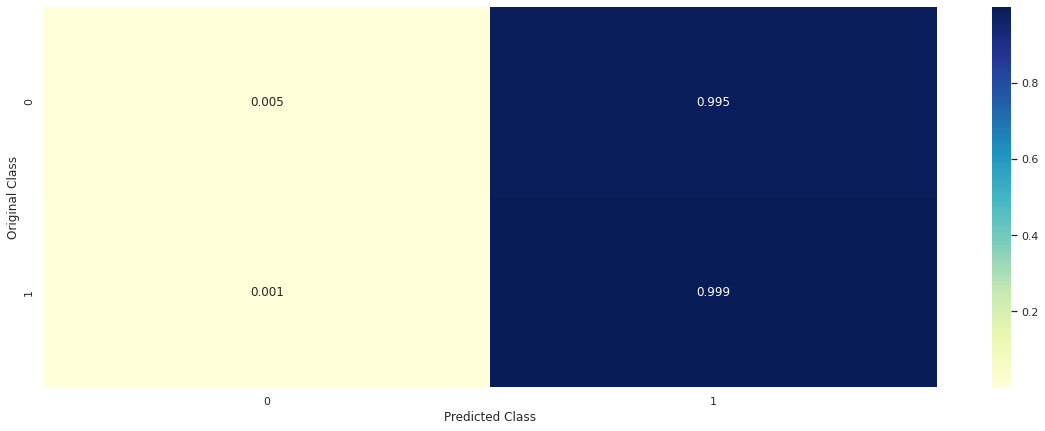

In [101]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train, y_train, X_cv, y_cv, clf)

## Test some points out

- Correctly predicted

In [102]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 1
Predicted Class Probabilities: [[0.3022 0.6978]]
Actual Class : [[1]]


- Incorrectly predicted

In [103]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 5456
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 1
Predicted Class Probabilities: [[0.3461 0.6539]]
Actual Class : [[0]]


# Linear Support Vector Machines

for alpha = 1e-06
Log Loss : 0.3437552901292161
for alpha = 1e-05
Log Loss : 0.3392162294716688
for alpha = 0.0001
Log Loss : 0.3372957355249959
for alpha = 0.001
Log Loss : 0.33654962358559115
for alpha = 0.01
Log Loss : 0.3406318923936145
for alpha = 0.1
Log Loss : 0.33714109225108807
for alpha = 1
Log Loss : 0.3193831797221952
for alpha = 10
Log Loss : 0.34723115385559966
for alpha = 100
Log Loss : 0.3081344831530419
for alpha = 1000
Log Loss : 0.3081429028124793
for alpha = 10000
Log Loss : 0.30809919918544515
for alpha = 100000
Log Loss : 0.30861717724991755


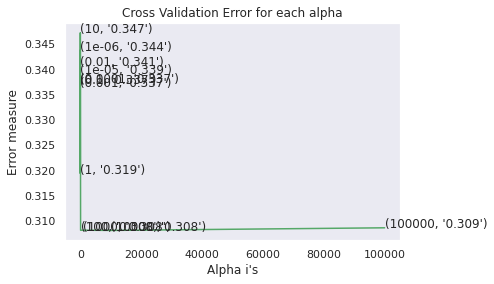

For values of best alpha =  10000 The train log loss is: 0.30915405397850865
For values of best alpha =  10000 The cross validation log loss is: 0.30809919918544515
For values of best alpha =  10000 The test log loss is: 0.3126569914606996


In [106]:
alpha = [10 ** x for x in range(-6, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.30809919918544515
Number of mis-classified points : 0.1228021069238403

-------------------- Confusion matrix --------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


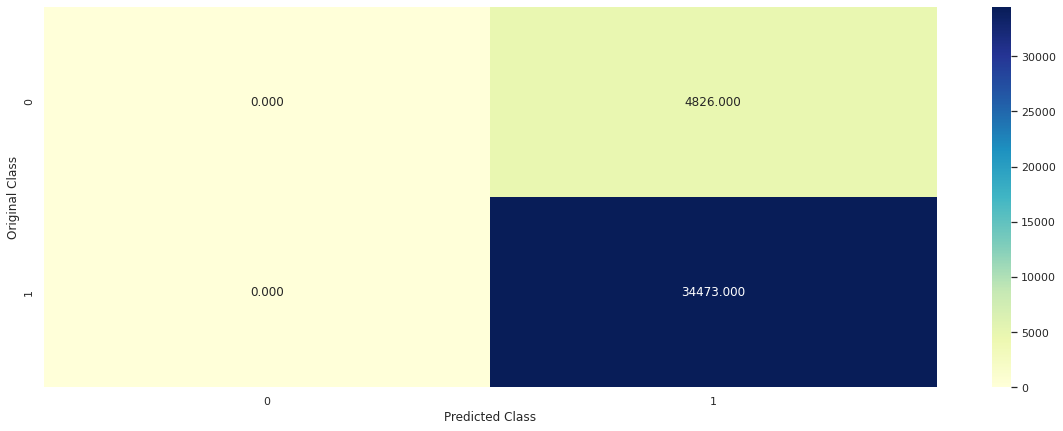

-------------------- Precision matrix (Columm Sum=1) --------------------


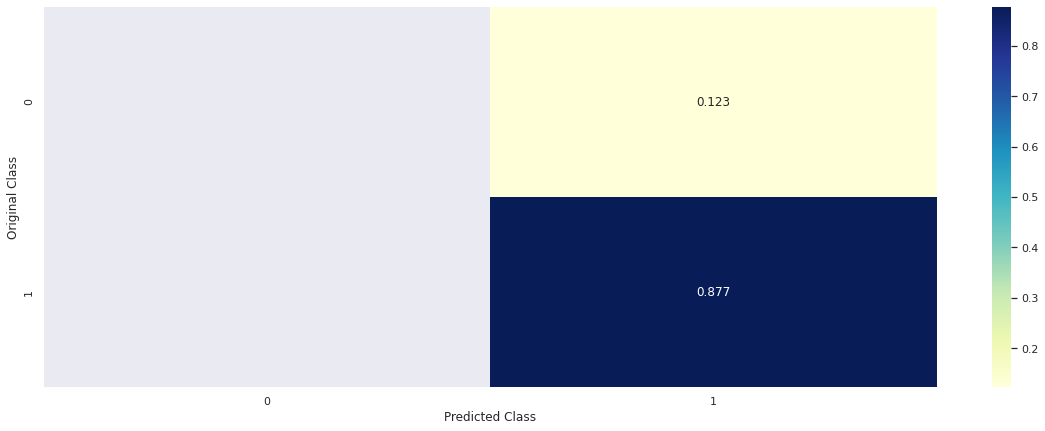

-------------------- Recall matrix (Row sum=1) --------------------


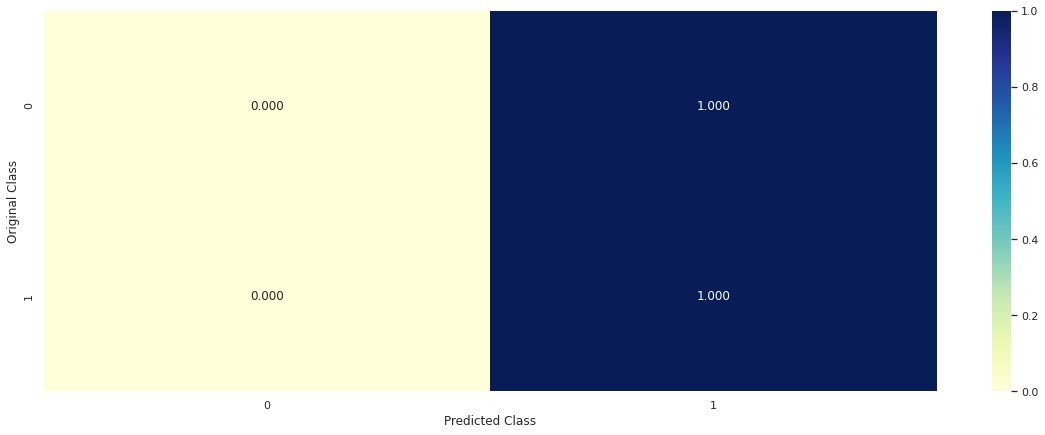

In [107]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(X_train, y_train, X_cv, y_cv, clf)

## Test some points out

- Correctly Classified

In [108]:
# from tabulate import tabulate
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 1
Predicted Class Probabilities: [[0.0735 0.9265]]
Actual Class : [[1]]


- Incorrectly Classified

In [109]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 5456
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 1
Predicted Class Probabilities: [[0.3741 0.6259]]
Actual Class : [[0]]


## Random Forest

In [110]:
alpha = [100,300,500]
max_depth = [3, 5]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        sig_clf_probs = sig_clf.predict_proba(X_cv)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best estimator = ', 
      alpha[int(best_alpha/2)], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  3
Log Loss : 0.2784886966047876
for n_estimators = 100 and max depth =  5
Log Loss : 0.2669527019385133
for n_estimators = 300 and max depth =  3
Log Loss : 0.2782845046015356
for n_estimators = 300 and max depth =  5
Log Loss : 0.26715790109268056
for n_estimators = 500 and max depth =  3
Log Loss : 0.2785084940520751
for n_estimators = 500 and max depth =  5
Log Loss : 0.2672758826707215
For values of best estimator =  100 The train log loss is: 0.26520610571689845
For values of best estimator =  100 The cross validation log loss is: 0.2669527019385133
For values of best estimator =  100 The test log loss is: 0.27225935017934794


Log loss : 0.2669527019385133
Number of mis-classified points : 0.0952187078551617

-------------------- Confusion matrix --------------------


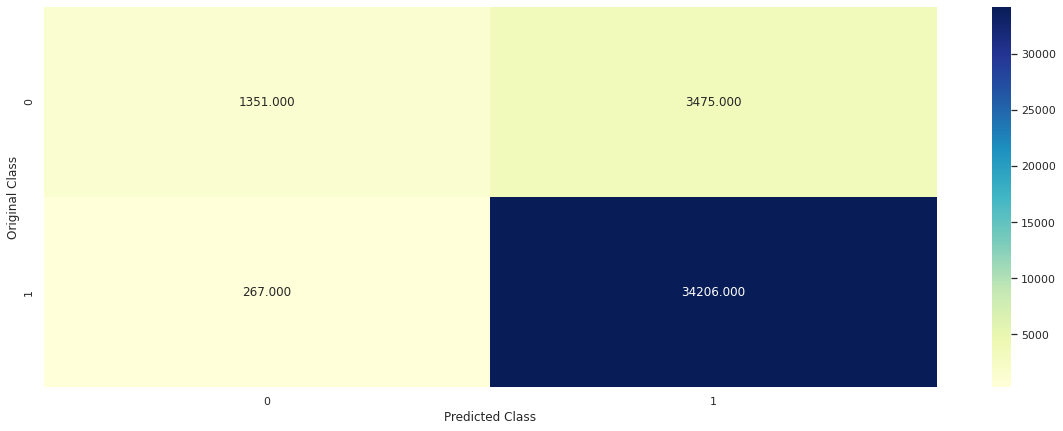

-------------------- Precision matrix (Columm Sum=1) --------------------


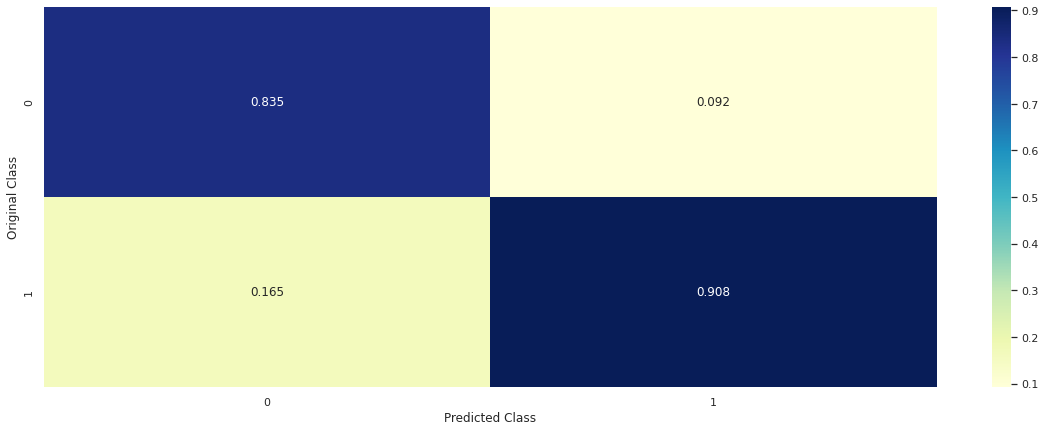

-------------------- Recall matrix (Row sum=1) --------------------


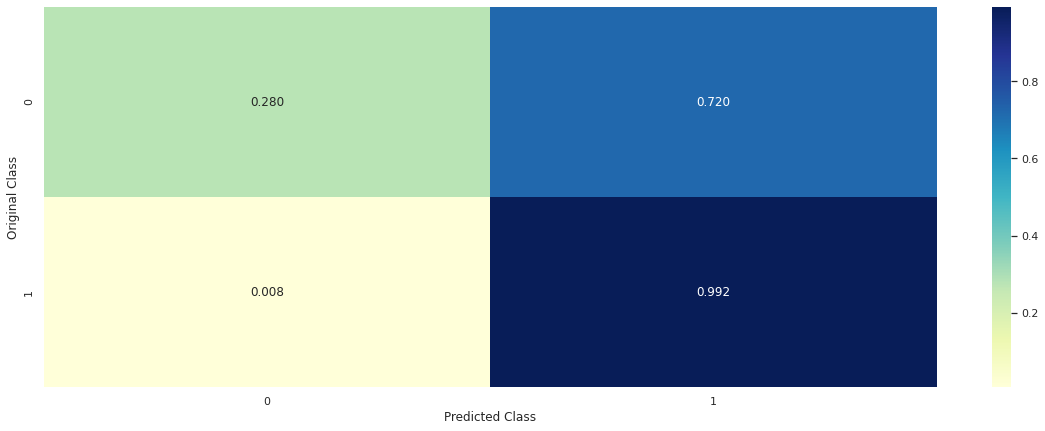

In [111]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(X_train, y_train,X_cv,y_cv, clf)

## Test some points out

- Correctly classified

In [112]:
test_point_index = 5
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1,-1)),4))
print("Actual Class :", yr[test_point_index].reshape(1,-1))
indices = np.argsort(-clf.feature_importances_)

Predicted Class : 1
Predicted Class Probabilities: [[0.0428 0.9572]]
Actual Class : [[1]]


- Incorrectly Classified

In [113]:
test_point_index = 5456
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1,-1)),4))
print("Actual Class :", yr[test_point_index].reshape(1,-1))
indices = np.argsort(-clf.feature_importances_)

Predicted Class : 1
Predicted Class Probabilities: [[0.2557 0.7443]]
Actual Class : [[0]]


## Let's try UPSAMPLING

In [119]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
print('Before Upsampling',X.shape, ' ', y.shape)
print('After Upsampling',X_over.shape, ' ', y_over.shape)

Before Upsampling (209593, 32)   (209593,)
After Upsampling (366862, 32)   (366862,)


In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=42)
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.25,random_state = 42)

In [121]:
#Use standardscaler to standardize the features

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_cv  = sc.transform(X_cv)
X_test  = sc.transform(X_test)

## Logistic Regression

for alpha = 1e-06
Log Loss : 0.618784864786861
for alpha = 1e-05
Log Loss : 0.5733931929069112
for alpha = 0.0001
Log Loss : 0.5390495776409138
for alpha = 0.001
Log Loss : 0.5217361177668973
for alpha = 0.01
Log Loss : 0.5225658118147732
for alpha = 0.1
Log Loss : 0.5282197968987324
for alpha = 1
Log Loss : 0.5377992266506653
for alpha = 10
Log Loss : 0.5435595725398746
for alpha = 100
Log Loss : 0.5445692726215877
for alpha = 1000
Log Loss : 0.544598017563088
for alpha = 10000
Log Loss : 0.5446731351013397
for alpha = 100000
Log Loss : 0.5446497846110937


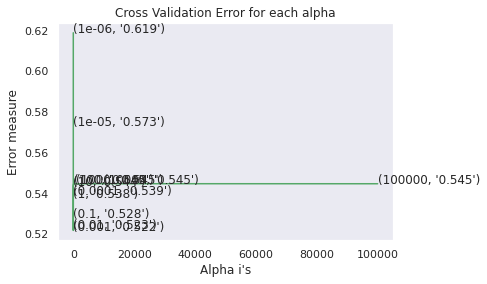

For values of best alpha =  0.001 The train log loss is: 0.5226767926664718
For values of best alpha =  0.001 The cross validation log loss is: 0.5217361177668973
For values of best alpha =  0.001 The test log loss is: 0.5228571389582798


In [122]:
alpha = [10 ** x for x in range(-6, 6)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train,y_train)
    sig_clf_probs = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train,y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The train log loss is:",
      log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The cross validation log loss is:",
      log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', 
      alpha[best_alpha], 
      "The test log loss is:",
      log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.5217361177668973
Number of mis-classified points : 0.2478666027010918

-------------------- Confusion matrix --------------------


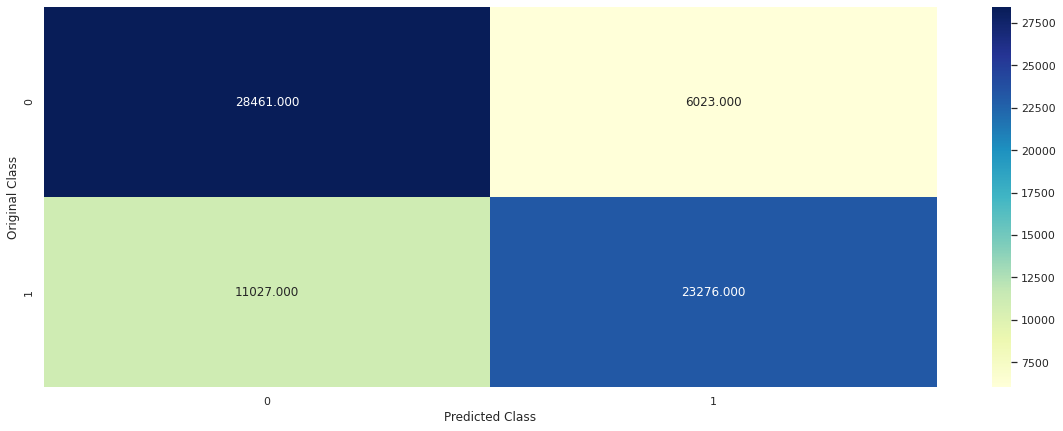

-------------------- Precision matrix (Columm Sum=1) --------------------


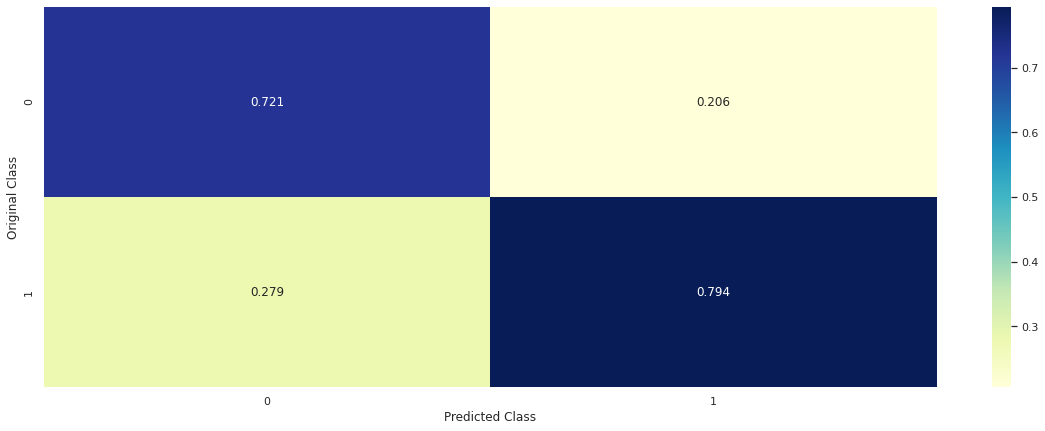

-------------------- Recall matrix (Row sum=1) --------------------


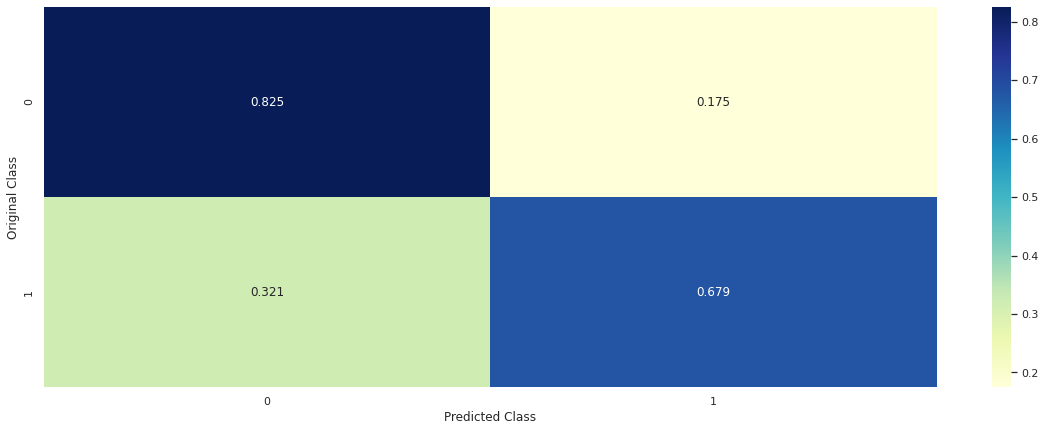

In [123]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(X_train, y_train, X_cv, y_cv, clf)

- This was correctly classified before upsampling by all models

In [124]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train,y_train)
test_point_index = 1
no_feature = 1000
predicted_cls = sig_clf.predict(Xr[test_point_index].reshape(1, -1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(Xr[test_point_index].reshape(1, -1)),4))
print("Actual Class :", yr[test_point_index].reshape(1, -1))
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]

Predicted Class : 0
Predicted Class Probabilities: [[0.8069 0.1931]]
Actual Class : [[1]]


## Lets summarize above models before proceeding with the feature engineering approach.

In [125]:
from prettytable import PrettyTable

ptable = PrettyTable()
ptable.title = "*** Model Summary *** [Performance Metric: Log-Loss]"
ptable.field_names=["Model Name","Train LogLoss","CV LogLoss","Test LogLoss","% Misclassified Points"]
ptable.add_row(["Logistic Regression With Class balancing","0.298","0.297","0.302","0.122"])
ptable.add_row(["Linear SVM","0.309","0.308","0.312","0.122"])
ptable.add_row(["Random Forest Classifier ","0.265","0.266","0.272","0.095"])
ptable.add_row(["Logistic Regression With Class balancing(UPSAMPLING) ","0.522","0.521","0.522","0.247"])


print(ptable)

+-------------------------------------------------------+---------------+------------+--------------+------------------------+
|                       Model Name                      | Train LogLoss | CV LogLoss | Test LogLoss | % Misclassified Points |
+-------------------------------------------------------+---------------+------------+--------------+------------------------+
|        Logistic Regression With Class balancing       |     0.298     |   0.297    |    0.302     |         0.122          |
|                       Linear SVM                      |     0.309     |   0.308    |    0.312     |         0.122          |
|               Random Forest Classifier                |     0.265     |   0.266    |    0.272     |         0.095          |
| Logistic Regression With Class balancing(UPSAMPLING)  |     0.522     |   0.521    |    0.522     |         0.247          |
+-------------------------------------------------------+---------------+------------+--------------+----------

# CONCLUSION:
- All the models performed better than the random model, which makes sense.
- From the pretty table we can see that , __RandomForest__ performed best here.
- Even the overfitting is not present if we check the train and test logloss, they are very close
- Over sampling method was also applied on the training data to make the data more balanced, but it gave worse results
